# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** Elisabetta Pagliara, Liangwei Chen
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [6]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

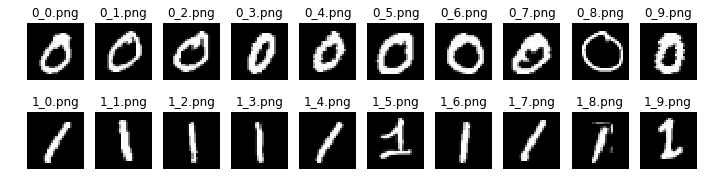

In [7]:
import skimage
from skimage.io import imread_collection
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [8]:
# Necessary libraries
import cv2
import numpy as np

In [50]:
def find_fourier_descriptor(img, l = 1):
    """
    Find the l-th fourier descriptor for given img
    Params: img: np.array
            l: int
    Return: (x, y)
    """

    # Get test img
    test_img = img

    # Convert gray img to binary img
    thrs = (test_img > 0) * 255
    thrs = thrs.astype(np.uint8)

    # Find contour
    contours, hier = cv2.findContours(thrs, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # For simplicity we only take the longest contour
    contour = sorted(contours, key = lambda x: len(x))[-1]

    # Normalization
    contour = contour.reshape(-1, 2).T

    contour -= np.mean(contour, axis = 1).astype(np.int).reshape(2, 1)

    # Get length of contour
    N = len(contour[0])

    # Get real part of contour
    real = contour[0]

    # Get imaginary part of contour
    imginary = contour[1] * 1j

    # Build Fourier descriptor for the contour

    # First Fourier descriptor
    f = np.sum((real + imginary) * np.exp(-2 * np.pi * l * 1j / N * np.arange(N)))

    # Second Fourier descriptor
    # f2 = np.sum((real + imginary) * np.exp(2 * np.pi * 1j / N * np.arange(0, 2 * N, 2)))

    # Return real and imaginary part of f1
    return f.real, f.imag

In [263]:
# Get 1st fourier descriptor for all img with label zero
zero_f1 = np.asarray([find_fourier_descriptor(img) for img in zeros_im])

In [264]:
# Get 1st fourier descriptor for all img with label one
one_f1 = np.asarray([find_fourier_descriptor(img) for img in ones_im])

Text(0, 0.5, 'f1 imaginary')

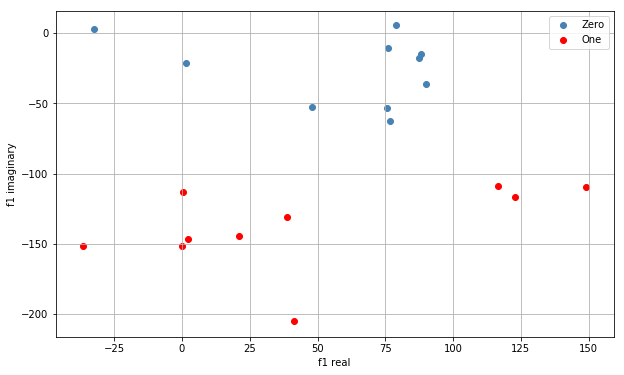

In [265]:
# Visualize the results
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
ax.scatter(zero_f1[:, 0], zero_f1[:, 1], c = 'steelblue', label = 'Zero')
ax.scatter(one_f1[:, 0], one_f1[:, 1], c = 'red', label = 'One')
ax.legend()
ax.grid(True)
ax.set_xlabel('f1 real')
ax.set_ylabel('f1 imaginary')

To check the robustness of our feature generator, we conduct rotation to the img. Notice that translation is not necessary since we have done normalization in our implementation.

In [13]:
# Get center 
center = zeros_im[0].shape
center = (center[0] / 2, center[1] / 2)

In [14]:
def rotate_img(img, deg = 90):
    """
    Rotate img by given deg
    Param:  img: np.array
            deg: int
    Return: rorated_img: np.array
    """
    
    # Get center of image
    center = img.shape
    center = (center[0] / 2, center[1] / 2)
    
    return cv2.warpAffine(img, cv2.getRotationMatrix2D(center, deg, 1.0), img.shape)

In [15]:
# Rotation
rotated_zeros_im = [rotate_img(img, deg) for img in zeros_im \
                                           for deg in [90, 180, 270]]

rotated_ones_im = [rotate_img(img, deg) for img in ones_im \
                                          for deg in [90, 180, 270]]

Text(0.5, 1.0, 'Original img')

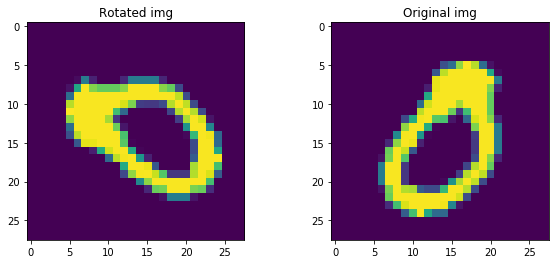

In [227]:
# Visualize rotation 
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(121)
ax.imshow(rotated_zeros_im[0])
ax.set_title('Rotated img')
ax = fig.add_subplot(122)
ax.imshow(zeros_im[0])
ax.set_title('Original img')

In [60]:
# Compute f1 for augmented zeros images
zero_f1_aug = np.asarray([find_fourier_descriptor(img) for img in rotated_zeros_im + list(zeros_im)])

# Compute f1 for augmented ones images
one_f1_aug = np.asarray([find_fourier_descriptor(img) for img in rotated_ones_im + list(ones_im)])

Text(0, 0.5, 'f1 imaginary')

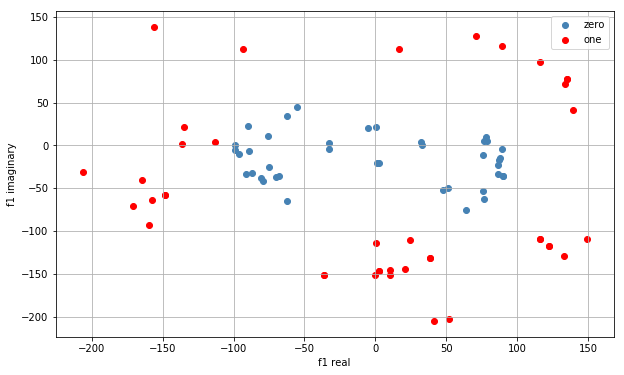

In [261]:
# Visualize the results
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
ax.scatter(zero_f1_aug[:, 0], zero_f1_aug[:, 1], c = 'steelblue', label = 'zero')
ax.scatter(one_f1_aug[:, 0], one_f1_aug[:, 1], c = 'red', label = 'one')
ax.legend()
ax.grid(True)
ax.set_xlabel('f1 real')
ax.set_ylabel('f1 imaginary')

The distribution of zeros are closed origin while the distribution of ones are away from origin.

This is exactly what we expect based on observing the visualization of two classes before rotating.

However, we may want invariance to rotation and even scaling to ease the workload of the classifier.

We achieve our goal by setting the the attribute to be (|f1|, |f2|) since they are invariant to rotation.

In [229]:
# Get f2, f3 for rotated and original imgs
zero_f2 = [find_fourier_descriptor(img, 2) for img in rotated_zeros_im + list(zeros_im)]

one_f2 = [find_fourier_descriptor(img, 2) for img in rotated_ones_im + list(ones_im)]

zero_f3 = [find_fourier_descriptor(img, 3) for img in rotated_zeros_im + list(zeros_im)]

one_f3 = [find_fourier_descriptor(img, 3) for img in rotated_ones_im + list(ones_im)]

In [230]:
# Build |f1|, |f2|
zero_first_feature = np.sum(np.square(zero_f1_aug), axis = 1) 

one_first_feature = np.sum(np.square(one_f1_aug), axis = 1) 

zero_second_feature = np.sum(np.square(zero_f2), axis = 1) 

one_second_feature = np.sum(np.square(one_f2), axis = 1) 

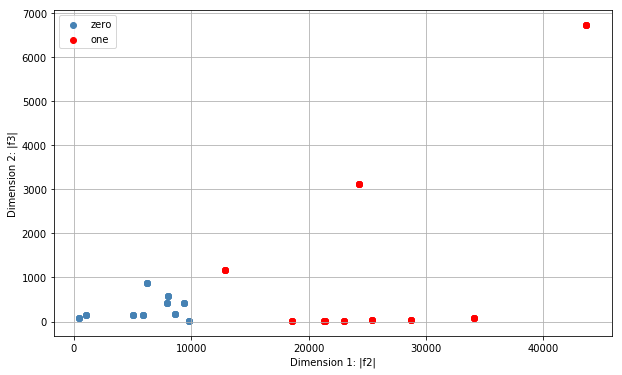

In [231]:
# Visualize the distribution of zero and one imgs
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
ax.scatter(zero_first_feature, zero_second_feature, c = 'steelblue', label = 'zero')
ax.scatter(one_first_feature, one_second_feature, c = 'red', label = 'one')
ax.legend()
ax.set_xlabel('Dimension 1: |f2|')
ax.set_ylabel('Dimension 2: |f3|')
ax.grid(True)

Notice that even though we rotate the imgs, all the rotated img have the same features as their original img. This successfully ease the load of our potential classifier. Meanwhile, the distinction between two class is still large enough for train a good classifier.

To be even more aggresive, what about we want the feature to be also invariant w.r.t. scaling?

Notice that |fi/fj| are invariant to both scaling and rotation.

In [89]:
# Build scaled img

# Get height and width
height, width = zeros_im.shape[1: 3]

# Build scaled img for zeros
scaled_zero_im = [cv2.resize(img, (2 * width, 2 * height), interpolation = cv2.INTER_CUBIC)
                  for img in zeros_im]

# Build scaled img for ones
scaled_one_im = [cv2.resize(img, (2 * width, 2 * height), interpolation = cv2.INTER_CUBIC)
                for img in ones_im]

Text(0.5, 1.0, 'Original img')

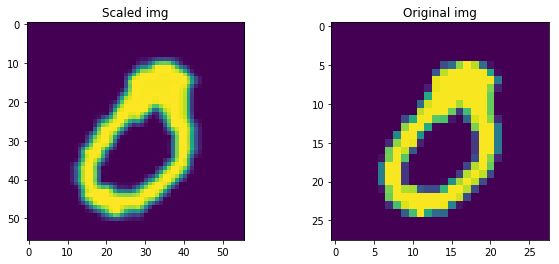

In [225]:
# Visualize scaled img and original img
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(121)
ax.imshow(scaled_zero_im[0])
ax.set_title('Scaled img')
ax = fig.add_subplot(122)
ax.imshow(zeros_im[0])
ax.set_title('Original img')

In [272]:
# Rebuild f1, f2, f3 for scaled and original imgs
zero_f1 = [find_fourier_descriptor(img, 1) for img in scaled_zero_im + list(zeros_im)]

one_f1 = [find_fourier_descriptor(img, 1) for img in scaled_one_im + list(ones_im)]

zero_f2 = [find_fourier_descriptor(img, 2) for img in scaled_zero_im + list(zeros_im)]

one_f2 = [find_fourier_descriptor(img, 2) for img in scaled_one_im + list(ones_im)]

zero_f3 = [find_fourier_descriptor(img, 3) for img in scaled_zero_im + list(zeros_im)]

one_f3 = [find_fourier_descriptor(img, 3) for img in scaled_one_im + list(ones_im)]

In [273]:
# Build feature invarant to both scaling and rotation
zero_first_feature = np.sqrt(np.sum(np.square(zero_f1), axis = 1)) / \
                        np.sqrt(np.sum(np.square(zero_f3), axis = 1)) 
                        
one_first_feature = np.sqrt(np.sum(np.square(one_f1), axis = 1)) / \
                        np.sqrt(np.sum(np.square(one_f3), axis = 1))

zero_second_feature = np.sqrt(np.sum(np.square(zero_f2), axis = 1)) / \
                        np.sqrt(np.sum(np.square(zero_f3), axis = 1)) 
                    
one_second_feature = np.sqrt(np.sum(np.square(one_f2), axis = 1)) / \
                        np.sqrt(np.sum(np.square(one_f3), axis = 1))

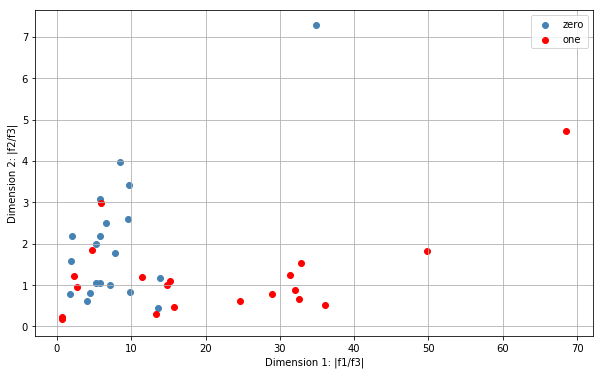

In [274]:
# Visualize the distribution of zero and one imgs
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
ax.scatter(zero_first_feature, zero_second_feature, c = 'steelblue', label = 'zero')
ax.scatter(one_first_feature, one_second_feature, c = 'red', label = 'one')
ax.legend()
ax.set_xlabel('Dimension 1: |f1/f3|')
ax.set_ylabel('Dimension 2: |f2/f3|')
ax.grid(True)

We found that the results are mixed and thus not useful for classifier building.

This may attribute to the fact that our 'scaling' are not exactly 'scaling' in the sense that we change the sizes of img.

Due to the fact that pixel coordinate can only take integer values, we are not able to do shrinking easily.
Besides, expanding may also be hard since one need to make sure the expanded object has closed shape instead of simply multiply a factor to object coordinates.

At the end of our analysis, we conclude that a the amplitudes of the first and second fourier descriptor are a powerful features for classification.

### 1.3 Additional method(s)
Add your implementation and discussion

In [24]:
# Import necessary libraries
import keras
from keras.layers import Dense
from keras import activations
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation

import scipy

from sklearn.decomposition import PCA
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.measure import regionprops

import pandas as pd
import matplotlib.patches as mpatches

from scipy.stats import entropy

### 1.3.1 Chamfer Distance

In this section we will describe a contour based description: the Chamfer Distance. First of all, we select two templates for class 1 and 0 by visual detection( small number of training data allows to do it); then, we define their skeleton and applied the function 'distance_transform' to obtain the distance map.



The other images of one and zeros are then all compared with these two distance map of the templates and a measure of similariy is extracted, taking into account the rotation and traslation invariance.

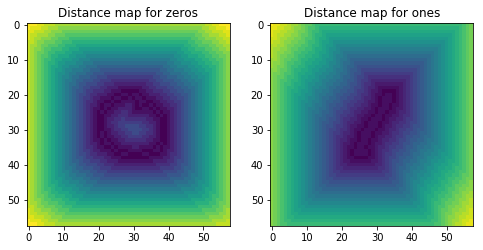

In [240]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)

#template for zeros
image_zeros = (zeros_im[8,:,:])
image=np.ones((image_zeros.shape[0],image_zeros.shape[1]))
contours, hierarchy = cv2.findContours(image_zeros, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
skeleton=cv2.drawContours(image, contours, -1, (255,255,255), 1)
skeleton=np.where(skeleton==255,0,1)
skeleton=np.pad(skeleton, (15, 15), 'edge')
distance_map_zeros=scipy.ndimage.morphology.distance_transform_cdt(skeleton)

plt.subplot(1,2,1)
plt.imshow(distance_map_zeros)
plt.title('Distance map for zeros')


#template for ones
image_ones = (ones_im[7,:,:])
image=np.ones((image_ones.shape[0],image_ones.shape[1]))
contours, hierarchy = cv2.findContours(image_ones, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
skeleton=cv2.drawContours(image, contours, -1, (255,255,255), 1)
#plt.imshow(skeleton,cmap='gray')

skeleton=np.where(skeleton==255,0,1)
skeleton=np.pad(skeleton, (15, 15), 'edge')# adding padding to prevent the problme of rotation
distance_map_ones=scipy.ndimage.morphology.distance_transform_cdt(skeleton)

plt.subplot(1,2,2)
plt.imshow(distance_map_ones)
plt.title('Distance map for ones')
plt.show()

Now, let's calculate the similarity between the other images and the two templates above.
We take the optimal trasformation of the images that minimizes the distance respect to both the templates. The distance will be the features used to classify the images.


In [241]:
def similarity(input1,input2,previous_distance,angle,i,j):
    
    distance=np.sum(input1*input2)
    
    if distance<previous_distance:
           return distance,angle,i,j
    else: 
          return None

In [242]:
#zeros and ones
def features_calculation(distance_map_zeros,shift_x,shift_y,skeleton,m):
    
    previous_distance=np.sum(distance_map_zeros.ravel()) #max possible value
    
    #traslation
    for i in range(0,distance_map_zeros.shape[0]-shift_x):
        
        for j in range(0,distance_map_zeros.shape[1]-shift_y):
            
            for angle in np.arange(0,360,10):
                
                img_rot = skimage.transform.rotate((skeleton.astype('float')),angle,resize=True)
                img_rot=np.where(img_rot>=np.mean(img_rot),1,0)#super bad but it's done to have binary images
                
                if (img_rot.shape> skeleton.shape)& ((i+img_rot.shape[0]<=distance_map_zeros.shape[0]) &( j+img_rot.shape[1]<=distance_map_zeros.shape[1])) :
                   
                    if similarity(img_rot,distance_map_zeros[i:i+img_rot.shape[0],j:j+img_rot.shape[1]],previous_distance,angle,i,j)!=None :
                        min_distance,min_angle,min_trasl_x,min_trasl_y= similarity(img_rot,distance_map_zeros[i:i+img_rot.shape[0],j:j+img_rot.shape[1]],previous_distance,angle,i,j)
                        previous_distance=min_distance
                        
                elif (img_rot.shape== skeleton.shape):
                   
                    if (similarity(img_rot,distance_map_zeros[i:i+shift_x,j:j+shift_y],previous_distance,angle,i,j)!=None): 
                        min_distance,min_angle,min_trasl_x,min_trasl_y= similarity(img_rot,distance_map_zeros[i:i+shift_x,j:j+shift_y],previous_distance,angle,i,j)
                        previous_distance=min_distance
            #
    print('Image: 0{}, min_distance:{}, angle:{}, traslation:[{},{}]'.format(m,previous_distance,min_angle,min_trasl_x,min_trasl_y ))            
    return min_distance

In [247]:

features=pd.DataFrame(index=np.arange(0,len(zeros_im)+len(ones_im)), columns=['Features0','Features1'])
image=np.ones((image_zeros.shape[0],image_zeros.shape[1]))

#all zeros images:
for m in range(len(zeros_im)):
    #find the contour of the image and threhsolding the contour
    contours, hierarchy = cv2.findContours(zeros_im[m,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    skeleton=cv2.drawContours(image-1, contours, -1, (255,255,255), 1)
    skeleton=np.where(skeleton==255,1,0)
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    min_distance=features_calculation(distance_map_zeros,shift_x,shift_y,skeleton[minr:maxr,minc:maxc],m)
    features.iloc[m,0]=min_distance
    min_distance=features_calculation(distance_map_ones,shift_x,shift_y,skeleton[minr:maxr,minc:maxc],m)
    features.iloc[m,1]=min_distance
    
    image=np.ones((image_zeros.shape[0],image_zeros.shape[1]))
    

#all the ones images
image=np.ones((image_zeros.shape[0],image_zeros.shape[1]))
for n in range(len(ones_im)):
    
#find the contour of the image and threhsolding the contour
    contours, hierarchy = cv2.findContours(ones_im[n,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    skeleton=cv2.drawContours(image-1, contours, -1, (255,255,255), 1)
    skeleton=np.where(skeleton==255,1,0)
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    min_distance=features_calculation(distance_map_zeros,shift_x,shift_y,skeleton[minr:maxr,minc:maxc],n)
    features.iloc[m+n+1,0]=min_distance
    min_distance=features_calculation(distance_map_ones,shift_x,shift_y,skeleton[minr:maxr,minc:maxc],n)
    features.iloc[m+n+1,1]=min_distance
    image=np.ones((image_zeros.shape[0],image_zeros.shape[1]))

Image: 00, min_distance:104, angle:180, traslation:[19,20]
Image: 00, min_distance:132, angle:0, traslation:[19,21]
Image: 01, min_distance:111, angle:0, traslation:[20,23]
Image: 01, min_distance:171, angle:0, traslation:[19,21]
Image: 02, min_distance:124, angle:0, traslation:[18,19]
Image: 02, min_distance:181, angle:0, traslation:[19,20]
Image: 03, min_distance:118, angle:180, traslation:[18,20]
Image: 03, min_distance:111, angle:180, traslation:[19,23]
Image: 04, min_distance:111, angle:180, traslation:[18,20]
Image: 04, min_distance:124, angle:180, traslation:[19,21]
Image: 05, min_distance:87, angle:270, traslation:[20,20]
Image: 05, min_distance:227, angle:0, traslation:[19,19]
Image: 06, min_distance:79, angle:0, traslation:[19,22]
Image: 06, min_distance:249, angle:180, traslation:[20,21]
Image: 07, min_distance:115, angle:90, traslation:[19,20]
Image: 07, min_distance:203, angle:180, traslation:[19,20]
Image: 08, min_distance:0, angle:0, traslation:[19,20]
Image: 08, min_dis

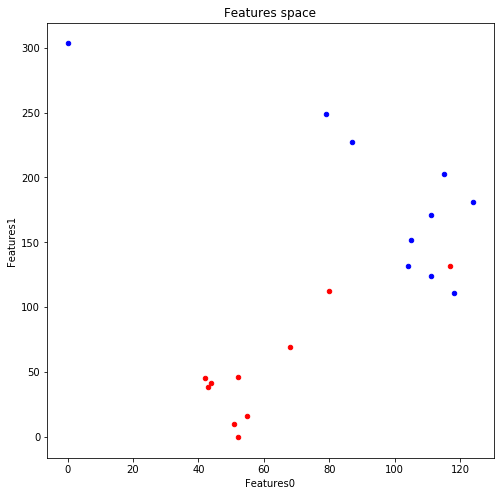

In [248]:
ax=features.iloc[0:len(zeros_im),:].plot.scatter(x='Features0',y='Features1',c='Blue')
features.iloc[len(zeros_im)::,:].plot.scatter(x='Features0',y='Features1',c='Red',ax=ax)
plt.title('Features space')
plt.show()

In [259]:
# Show features
features.head()

,Features0,Features1
0,20,22
1,20,24
2,19,24
3,21,22
4,23,19


limitation of the method:

1) difficult find a good template, 

2) tedius resize image and trasform to binary

Nevertheless, two clusters are able to be identified. The outlier could be explained by the fact the a one has really different shape from the other ones (not just a single bar).

### 1.3.2 Freeman

In [253]:
#no approximation because we want the relationship among all the points!!
#for the zero there are three contous while for one just one contours, 
# we should treat them separately !!!
import pandas as pd
cm=pd.Series([5 ,6 ,7, 4,'nan', 0, 3, 2, 1])

freeman_code_zero=[]
#for zero, take the one with biggest area
for m in range(len(zeros_im)):
    max_cont=0
    contours, hierarchy = cv2.findContours(zeros_im[m,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for i in range(len(contours)):
        if max_cont<len(contours[i]):
            contours[0]=contours[i]
            max_cont=len(contours[0])
            
    sb=np.roll(contours[0],(-1, -1),axis=(0,1))
    delta=sb-contours[0]
    if (np.abs(delta[-1][-1][1])>1) | (np.abs(delta[-1][-1][0])>1):
        delta=delta[0:len(delta)-1,:]
    idx=np.zeros((len(delta)))
    for i in range(len(delta)):
        idx[i]=3*delta[i][0][1] + delta[i][0][0]+4;

    freeman_code_zero.append(cm[idx.astype(int)].values)#remember two for one image



#for one , just one cases
freeman_code_one=[]
for m in range(len(ones_im)):
    contours, hierarchy = cv2.findContours(ones_im[m,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if (len(contours)>1):
        if(len(contours[0])<len(contours[1])):
            contours[0]=contours[1]
        
    sb=np.roll(contours[0],(-1, -1),axis=(0,1))
    delta=sb-contours[0]
    if (np.abs(delta[-1][-1][1])>1) | (np.abs(delta[-1][-1][0])>1):
        delta=delta[0:len(delta)-1,:]
    idx=np.zeros((len(delta)))
    for i in range(len(delta)):
        idx[i]=3*delta[i][0][1] + delta[i][0][0]+4;
        
    freeman_code_one.insert(m, cm[idx.astype(int)].values)

In [254]:
np.set_printoptions(precision=2)
# https://en.wikipedia.org/wiki/Wagner%E2%80%93Fischer_algorithm
# Original Paper http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.367.5281&rep=rep1&type=pdf
deletion_cost = 1
insertion_cost = 1
substitution_cost = 1
def fisher_wagner(line1, line2):
    #print("Fisher Wagner Distance: %s => %s"%(line1,line2))
    #print("Operations:")
    #print("\ti(X) means that character 'X' gets inserted in the resulting string at the current position")
    #print("\tn(X,X) means that two charcters were equal, no operation required")
    #print("\ts(X,Y) means that the character 'X' gets substituted with 'Y' at the current position ")
    #print("\td(X) means that character 'X' gets deleted from the current position")
    #print("\tNote: n(,), the noop for comparing empty string to empty string has been ommitted for clarity")
    # distance matrix
    d = np.zeros(shape=(len(line1)+1, len(line2)+1))
    ops = np.ndarray(shape=(len(line1)+1, len(line2)+1), dtype=np.dtype('S100') )
    ops[:] = ""  #clear array
    # ops[0,0] = "n( , )"
    for i in range(1,len(line1)+1):
            d[i,0] = d[i-1,0] + deletion_cost # the distance of any first string to an empty second string requires i deletions
            ops[i, 0] = "%sd(%c)"%(ops[i-1,0],line1[i-1])
    for j in range(1,len(line2)+1):
            d[0, j] = d[0,j-1] + insertion_cost# the distance of any second string to an empty first string
            ops[0,j] = "%si(%c)"%(ops[0,j-1],line2[j-1])
    #print("Cost matrix for empty strings")
    #print(d)
    #print("Operation matrix for empty strings")
    #print(ops)
    for j in range(1,len(line2)+1):
        for i in range(1,len(line1)+1):
                char1 = line1[i-1] # because strings in python are also zero indexed
                char2 = line2[j-1] # because strings in python are also zero indexed
                #print("\nStep(i=%i,j=%i)"%(i, j))
                #print("Goal: %s => %s"%(line1[0:i],line2[0:j]))
                #print("Comparing: '%s' to '%s'"%(char1, char2))
                if char1 == char2:
                    #print("\t=> equal, no change required")
                    d[i, j] = d[i-1, j-1]
                    ops[i,j]="%sn(%c,%c)"%(ops[i-1, j-1],char1,char2)
                else:
                    #print("\t=> not equal, need to modify something")
                    del_op_cost = d[i-1,j  ] + deletion_cost     # deletion
                    ins_op_cost = d[i  ,j-1] + insertion_cost    # insertion
                    subs_op_cost   = d[i-1,j-1] + substitution_cost # substitution_cost
                    #print("\tCost of reaching goal via del:  %sd(%c): %i"%(ops[i-1, j], char1, del_op_cost))
                    #print("\tCost of reaching goal via ins:  %si(%c): %i"%(ops[i ,j-1], char2, ins_op_cost))
                    #print("\tCost of reaching goal via sub:  %ss(%c,%c): %i"%(ops[i-1, j-1], char1, char2, subs_op_cost))
                # assign performed operation
                    if del_op_cost<ins_op_cost and del_op_cost<subs_op_cost:
                                        ops[i,j]="%sd(%c)"%(ops[i-1, j], char1)
                    elif ins_op_cost<del_op_cost and ins_op_cost<subs_op_cost:
                                        ops[i,j]="%si(%c)"%(ops[i ,j-1], char2)
                    else: # substitution
                                        ops[i,j]="%ss(%c,%c)"%(ops[i-1, j-1], char1, char2)
                    d[i, j] = min(del_op_cost, ins_op_cost, subs_op_cost)
                                       
                    #print("Cost Matrix:")
                    #print(d)
                    #print("Traces Matrix:")
                    #print(ops)
    #print(d)           
    return d[len(line1), len(line2)]#3,2
#print(fisher_wagner("ABV", "FV"))


In [256]:
template_zeros=freeman_code_zero[6]
template_ones=freeman_code_one[7]

features=pd.DataFrame(index=np.arange(0,len(zeros_im)+len(ones_im)), columns=['Features0','Features1'])
for i in range(len(freeman_code_zero)):
    features.iloc[i,0]=fisher_wagner(freeman_code_zero[i],template_zeros)
    features.iloc[i,1]=fisher_wagner(freeman_code_zero[i],template_ones)
for j in range(len(freeman_code_one)):
    features.iloc[i+j+1,0]=fisher_wagner(freeman_code_one[j],template_zeros)
    features.iloc[i+j+1,1]=fisher_wagner(freeman_code_one[j],template_ones)
        

In [258]:
# Show features 
features.head()

,Features0,Features1
0,20,22
1,20,24
2,19,24
3,21,22
4,23,19


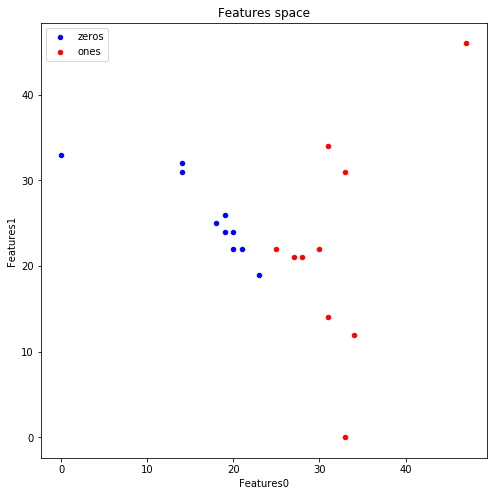

In [260]:
ax=features.iloc[0:len(zeros_im),:].plot.scatter(x='Features0',y='Features1',c='Blue')
features.iloc[len(zeros_im)::,:].plot.scatter(x='Features0',y='Features1',c='Red',ax=ax)
plt.title('Features space')
plt.legend(['zeros','ones'])
plt.show()

The division in classes is really hard and this is due to the completely different shape that both zero and ones have and also due to a bad segmentation.

### 1.3.3 PCA

We continue with linear dimensionality reduction, namely PCA.

The flatted img is regarded as the original features.

In [329]:
# Flat imgs
flatten_zeros = [img.flatten() for img in list(zeros_im) + rotated_zeros_im]

flatten_ones = [img.flatten() for img in list(ones_im) + rotated_ones_im]

In [330]:
# Conduct PCA
pca = PCA(n_components = 2)

results = pca.fit_transform(flatten_zeros + flatten_ones)

projected_zeros = results[: len(flatten_zeros)]

projected_ones = results[len(flatten_ones): ]

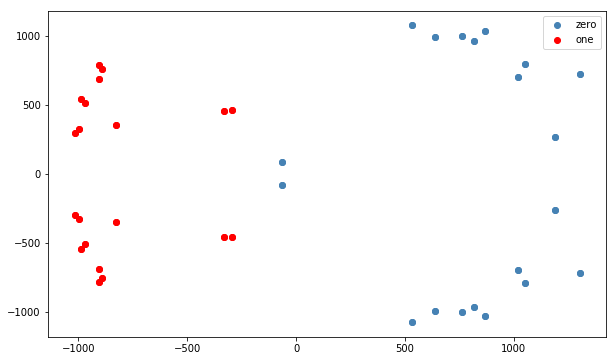

In [331]:
# Visualize
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
ax.scatter(projected_zeros[:, 0], projected_zeros[:, 1], c = 'steelblue', label = 'zero')
ax.scatter(projected_ones[:, 0], projected_ones[:, 1], c = 'red', label = 'one')
ax.legend()

### 1.3.4 Single layer ANN

The last layer of the network is regarded as features.

In [172]:
# Build model

# This trivial model is collected from the internet
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('softmax')) # This special "softmax" activation among other things,

model.compile(loss = 'mean_squared_error',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [169]:
# Build x
x = np.asarray((rotated_zeros_im + rotated_ones_im)).reshape((-1, zeros_im[0].shape[0] * \
                                                                     zeros_im[0].shape[1]))

# Normalize x 
x = x / 255
x -= np.mean(x)
x /= np.std(x)

In [170]:
# Build y
y = np.asarray([0] * len(rotated_zeros_im) + [1] * len(rotated_ones_im))

# Convert y to categorical
y = np_utils.to_categorical(y, 2)

In [171]:
# Shuffle data
mask = np.random.permutation(len(x))

x = x[mask]
y = y[mask]

In [174]:
# Train
model.fit(x, y, epochs = 10)

Epoch 1/10
80/80 [==============================] - 0s 445us/step - loss: 3.2340e-08 - acc: 1.0000
Epoch 2/10
80/80 [==============================] - 0s 438us/step - loss: 7.5511e-07 - acc: 1.0000
Epoch 3/10
80/80 [==============================] - 0s 486us/step - loss: 1.2380e-08 - acc: 1.0000
Epoch 4/10
80/80 [==============================] - 0s 543us/step - loss: 8.4531e-10 - acc: 1.0000
Epoch 5/10
80/80 [==============================] - 0s 616us/step - loss: 1.8766e-08 - acc: 1.0000
Epoch 6/10
80/80 [==============================] - 0s 607us/step - loss: 2.0788e-10 - acc: 1.0000
Epoch 7/10
80/80 [==============================] - 0s 560us/step - loss: 5.6586e-07 - acc: 1.0000
Epoch 8/10
80/80 [==============================] - 0s 663us/step - loss: 4.0469e-09 - acc: 1.0000
Epoch 9/10
80/80 [==============================] - 0s 568us/step - loss: 2.3232e-09 - acc: 1.0000
Epoch 10/10
80/80 [==============================] - 0s 550us/step - loss: 6.2540e-09 - acc: 1.0000


In [176]:
# Get last layer as feature vector
feature_vec = model.predict_proba(x)

In [191]:
# Get zero and one feature vectors

zero_feature_vec = feature_vec[y[::, 1] == 0]

one_feature_vec = feature_vec[y[::, 1] == 1]

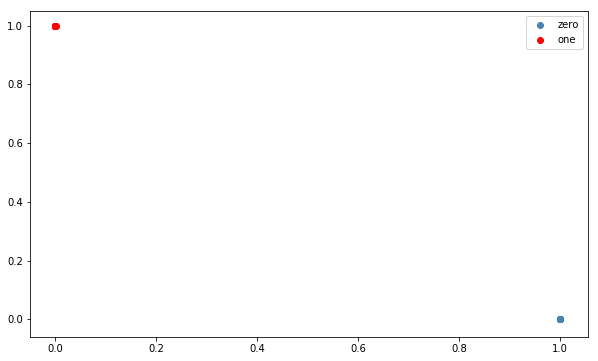

In [193]:
# Visualize feature vector
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
ax.scatter(zero_feature_vec[::, 0], zero_feature_vec[::, 1], c = 'steelblue', label = 'zero')
ax.scatter(one_feature_vec[::, 0], one_feature_vec[::, 1], c = 'red', label = 'one')
ax.legend()

Notice that this feature encoding seems to be perfect. This is due to the lack of training data, which may lead to severe overfitting.

This disadvantage can be overcome by bringing more data. As the success of neural network on recognition on MNIST dataset shows, with sufficient amount of data, we can encode the figures to any dimension properly.